In [40]:
# import yahoo finance data
import yfinance as yf
# import stockstats data
from stockstats import StockDataFrame as ss

# import necessary libraries
import matplotlib as mp
import numpy as np
import pandas as pd
import pytz
import warnings
import time
import random
import statistics
import pydoc
import os
import pyarrow
import pandas_gbq
import statsmodels
import tensorflow

#import libraries for SARIMA model
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from datetime import timedelta
from datetime import date

Downlaod Data for Apple Stock

In [ ]:
apple_ticker = yf.Ticker("AAPL")
apple_data = yf.download("AAPL", start = '2004-01-01', interval = '1d')
apple_df = ss.retype(apple_data)

apple_data[['stochrsi', 'macd', 'mfi']] = apple_df[['stochrsi', 'macd', 'mfi']]
print(apple_data)
print(apple_ticker.get_capital_gains)

Load Data Into SQL -> BigQuery

In [ ]:
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

# import google cloud service account and bigquery
from google.oauth2 import service_account
from google.cloud import bigquery

# specify google cloud project information
credentials = service_account.Credentials.from_service_account_file(
    'black-vehicle-406619-bf2e31773163.json')
project_id = 'black-vehicle-406619'
client = bigquery.Client(project=project_id, credentials=credentials)
dataset_id = 'stocks_ds'
table_id = '20yrs_stockdata'
table_path = f"{project_id}.{dataset_id}.{table_id}"

# specify load reqs
load_info = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
load_data = client.load_table_from_dataframe(apple_data, table_path, job_config=load_info)
load_data.result()

Preparing Data: SARIMA Model

In [25]:
#Seasonal - fit stepwise auto-ARIMA
#!pip install pmdarima

# Remove any duplicate index
apple_data = apple_data.loc[~apple_data.index.duplicated(keep='first')]

#Filter only required data

apple_data = apple_data[['close']]





In [27]:
#Scale the APPL data into a standard range using MinMaxScaler ()

Feature_Scaler = MinMaxScaler()

#Transform current APPL data

apple_transformed = pd.DataFrame(np.squeeze(Feature_Scaler.fit_transform(apple_data), axis=1), columns=["Close"], index=apple_data.index)

SARIMA Model

In [29]:

sarima_model = pm.auto_arima(apple_transformed["Close"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12, #12 is the frequncy of the cycle
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

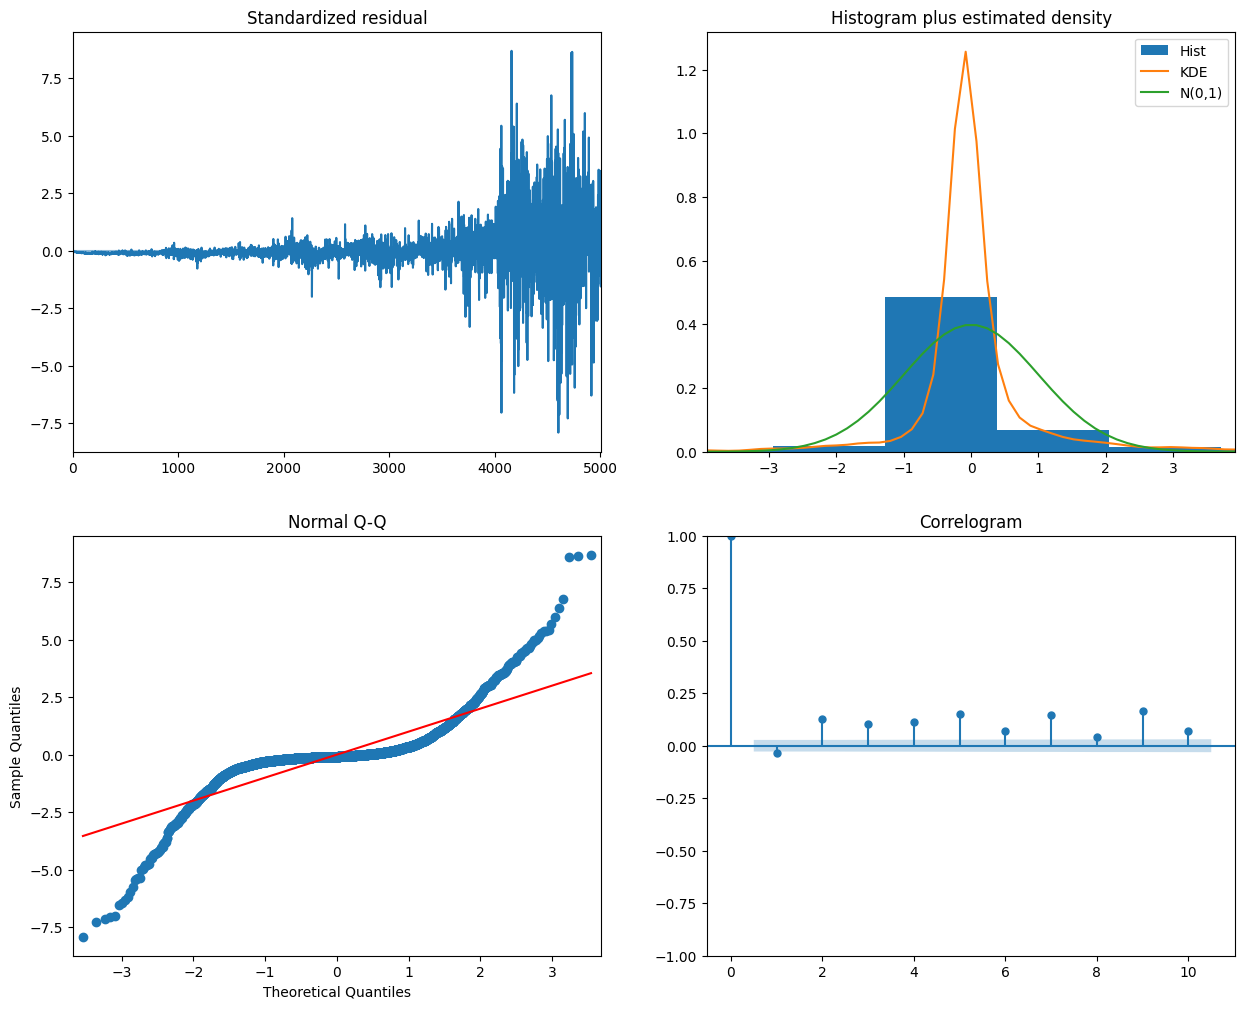

In [32]:
sarima_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [35]:
# Serialize with Pickle
with open('sarima_model.pkl', 'wb') as pkl:
    pickle.dump(sarima_model, pkl)

# Now read it back and make a prediction
with open('sarima_model.pkl', 'rb') as pkl:
    loaded_model = pickle.load(pkl)

In [41]:
def forecast(model, df, forecast_date):
    # Forecast
    n_periods = (datetime.strptime(forecast_date, '%Y-%m-%d') - df.index[-1]).days
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted.values, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    df_result = pd.concat([df, fitted_series, lower_series, upper_series], axis=1)
    df_result.columns = ["Actual", "Prediction", "Low", "High"]

    for column in df_result.columns:
      df_result[column] = Feature_Scaler.inverse_transform(df_result[column].values.reshape(-1,1))


    return df_result

In [42]:
test=forecast(loaded_model, apple_transformed, "2023-12-13")

ValueError: Prediction must have `end` after `start`.